In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import random
import seaborn as sns
import re
import sys
from pathlib import Path
import tempfile

In [15]:
result_df = pd.read_csv('../results/refit_bsrn_5T.csv', index_col=[0, 1])
result_df.sample(3)

,,before,naive,educated_forward,educated,upper_bound
house_7_5T.hdf,washing_machine_power,35.010577,36.299011,37.265243,38.417763,41.263759
house_18_5T.hdf,washing_machine_power,34.263629,34.437147,34.617060,34.643799,34.891824
house_5_5T.hdf,dishwasher_power,44.320330,45.962801,46.570446,47.072634,52.822562


In [16]:
def house_number_from_filename(filename):
    m = re.match(r'^house_(\d+)_\d+[a-zA-Z]+.hdf$', filename)
    if m is None:
        raise ValueError(f'unsupported filename format ({filename})')
    return int(m[1])

def plot_results(result_df):
    result_df = result_df.T
    
    labels = sorted(
        set(result_df.columns.get_level_values(0)),
        key=house_number_from_filename,
    )
    algorithem = ['naive forward','educated forward','educated forward/backward']
    colors = {
        'blue': ['deepskyblue','royalblue','navy'],
        'green': ['palegreen','mediumseagreen','darkgreen'],
        'red': ['coral','red','firebrick'],
    }
    men_means = [20, 34, 30, 35, 27]
    women_means = [25, 32, 34, 20, 25]

    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars
    appliances = {
        'dishwasher_power': [],
        'washing_machine_power': [],
        'tumble_dryer_power': [],
    }
    
    result_df = result_df.T
    result_df = result_df.reindex(index=pd.MultiIndex.from_product([labels, appliances.keys()]))
    result_df = result_df.T
    
    for house in labels:
        for appliance in result_df[house].columns:
            appliances[appliance].append(result_df[house][appliance]['naive':'educated'].values)
    dishwasher = np.array(appliances['dishwasher_power']).transpose()
    tumble_dryer = np.array(appliances['tumble_dryer_power']).transpose()
    washing_machine = np.array(appliances['washing_machine_power']).transpose()

    fig, ax = plt.subplots(figsize=(12,12))
    
    width_small = width / 3

    pos = - width
    sub_pos = -width_small
    for i in range(3):
        ax.bar(x+pos+sub_pos, dishwasher[i], width=width_small, label='dishwasher '+algorithem[i],color=colors['blue'][i])
        sub_pos += width_small

    pos += width
    sub_pos = -width_small
    for i in range(3):
        ax.bar(x+pos+sub_pos, tumble_dryer[i], width=width_small, label='tumble_dryer '+algorithem[i],color=colors['green'][i])
        sub_pos += width_small

    pos += width
    sub_pos = -width_small
    for i in range(3):
        ax.bar(x+pos+sub_pos, washing_machine[i], width=width_small, label='washing_machine '+algorithem[i],color=colors['red'][i])
        sub_pos += width_small

    x=0
    for house in labels:
        pos = - width
        for appliance in sorted(result_df[house].columns):
            ax.vlines(x+pos, result_df[house][appliance]['before'],result_df[house][appliance]['upper_bound'])
            ax.hlines(result_df[house][appliance]['before'], x+pos-width,x+pos+width)
            pos += width
            if len(result_df[house].columns)==2:
                pos += width
        x+=1

    x = np.arange(len(labels))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title('Effect of load-shifting on PV self-consumption')
    ax.set_xlabel('REFIT house number')
    ax.set_xticks(x)
    ax.set_xticklabels([house_number_from_filename(filename) for filename in labels])
    ax.set_ylabel('PV self-consumption [%]')
    ax.set_ylim(0, 100)
    ax.legend()

    fig.tight_layout()

    plt.show()

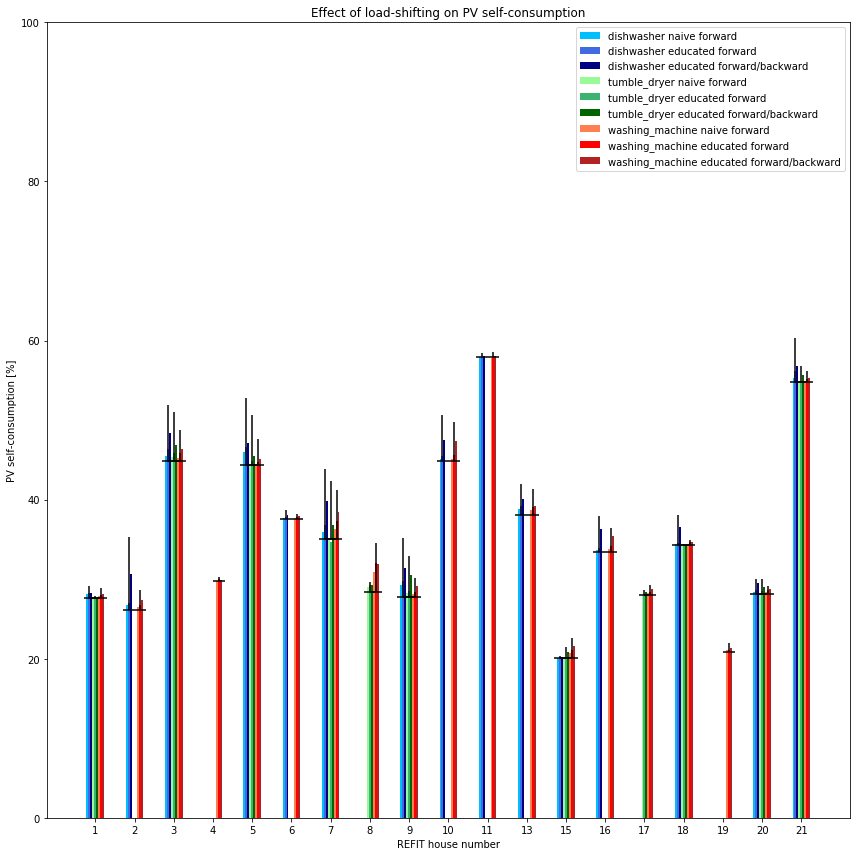

In [17]:
plot_results(result_df)